In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline

from swap import Swap,priceSwap
from marketSetup import simulateOIS,simulateSurvivalProb
from valuationAdjustment import calculatePVEE

### 3 CVA/DVA Exercise

###### Simulate OIS curve

From equation (18) and (19) from [1], we get $$\sigma_{22}=\sigma_2$$
$$\sigma_{21}=\sigma_1 \times \rho_x$$
$$\sigma_{11}=\sqrt{\sigma_1^2-\sigma_{21}^2}=\sqrt{\sigma_1^2-\sigma_1^2\times \rho_x^2}$$
For $y(t)$, we calculate the involved integral manually:
$$\int_{0}^{t}{a(u)^T a(u)du}=\int_{0}^{t} \begin{bmatrix} \sigma_{11}^2e^{2\kappa_1u} & \sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u}\\\sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u} & \sigma_{22}^2e^{2\kappa_2u} \end{bmatrix}du \\=\begin{bmatrix} \frac{\sigma_{11}^2+\sigma_{21}^2}{2\kappa_1}(e^{2\kappa_1t}-1) & \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) \\ \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) & \frac{\sigma_{22}^2}{2\kappa_2}(e^{2\kappa_2t}-1)\end{bmatrix}$$
For $P(t,x(t),T)$, we know $$P(t,x(t),T)=e^{-\int_{t}^{T} f(t,x(t),u)du}$$ where $$f(t,x(t),u)=f(0,u)+M(t,u)^T(x(t)+y(t)G(t,u))$$
Since $f(0,u)$ is constant, then $$P(t,x(t),T)=e^{-f(0,T)+f(0,t)}e^{-x(t)\int_{t}^{T}M(t,u)du}e^{-y(t)\int_{t}^{T}M(t,u)^TG(t,u)du}\\=\frac{P(0,T)}{P(0,t)}exp\big(-G(t,T)^Tx(t)-\frac{1}{2}G(t,T)^Ty(t)G(t,T)\big)$$
where $$M(t,T)=\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}$$
and $$G(t,T)=\int_{t}^{T}M(t,u)du=\int_{t}^{T}\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}du\\=\begin{bmatrix} \frac{1-\kappa_1(T-t)}{\kappa_1} \\ \frac{1-\kappa_2(T-t)}{\kappa_2}\end{bmatrix}$$

###### Inputs

In [2]:
num_simulation = 50000
sim_freq = 12

### Interest rate parameters
spread = 0.005 # spread i.e. f_LIBOR=f_OIS+spread
f0_OIS = 0.02
f0_LIBOR = f0_OIS+spread

### swap parameters
freq = 2
maturity = 10
coupon = 0.0265
notional = 150000000.

### Interest rate model parameters
sigma_r = 0.02
c = 0.35
kappa1,kappa2 = 0.02,0.1
rho_inf = 0.4
nu = np.sqrt(1./c/c - 1. - 2.*(rho_inf/c - 1.))
rho_x = (rho_inf/c - 1.)*nu
sigma_l = c * sigma_r
sigma1 = sigma_l
sigma2 = nu*sigma1

### Credit curve parameters
lbda0_B, lbda0_C = 0.01,0.03
sigmaB, sigmaC = 0.005,0.01
kappaB, kappaC = 0.1,0.1

rho_Bf, rho_Cf = 0.1,0.1
rho_BC = 0.75
rho_Br, rho_Cr = 0.25,0.25
rho_B1 = rho_Bf   # corr b/w lbdaB and x1
rho_C1 = rho_Cf   # corr b/w lbdaC and x1
rho_B2 = rho_Br*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_B1   # corr b/w lbdaB and x2
rho_C2 = rho_Cr*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_C1   # corr b/w lbdaC and x2

### correlation matrix among lbdaB,lbdaC,x1,x2 for simulation
corr = np.array([[1., rho_BC, rho_B1, rho_B2],\
                 [rho_BC, 1., rho_C1, rho_C2],\
                 [rho_B1, rho_C1, 1., rho_x],\
                 [rho_B2, rho_C2, rho_x, 1.]])
chol = np.linalg.cholesky(corr)

In [5]:
swap = Swap(maturity, coupon, freq, notional)
swap.__str__()


Tis = np.arange(1./freq,maturity+1e-6,1./freq)
ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)

num_simulation = 2000

prices_payer=[]
prices_receiver = []
P_OISs = []
P_LIBORs = []
X_Bs = []
X_Cs = []
lbdaBs = []
lbdaCs = []

for num in range(num_simulation):
    # simulate correlated 4-D brownian motion
    wt = chol.dot(np.random.normal(0,1./sim_freq,(4,sim_freq*maturity)))
    P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wt)
    X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
    price_one_path=[]
    price_one_path_payer = []
    for i in range(maturity*sim_freq):
        p =priceSwap(swap, 'payer', P_OIS, P_LIBOR, i, ts, Tis,sim_freq)
        price_one_path_payer.append(p)
        price_one_path.append(-p)
        
    prices_payer.append(price_one_path_payer)
    prices_receiver.append(price_one_path)
    P_OISs.append(P_OIS)
    P_LIBORs.append(P_LIBOR)
    X_Bs.append(X_B)
    X_Cs.append(X_C)
    lbdaBs.append(lbdaB)
    lbdaCs.append(lbdaC)

##### 1 Plot $PVEE(T)$ as seen from B as payer and receiver respectively

Payer [0.076027052740413686, 0.071298923871548125, 0.066543651849166607, 0.062863775181153408, 0.058833894446605466, 0.05490580660744683, 0.11432690507913484, 0.10969971302161782, 0.10547109998308488, 0.10112798449317449, 0.097843417103987002, 0.094327372833627812, 0.13347882246832279, 0.12962153724101591, 0.1256089971360258, 0.12091564316669876, 0.11626885070223379, 0.11236938925011508, 0.15190158839650691, 0.14802755506989995, 0.14405673168857439, 0.14038529743962219, 0.13705077596802367, 0.13359074152276224, 0.17079561307370422, 0.16645679673381064, 0.16227556714406718, 0.15856481232555389, 0.15497523250689788, 0.15159031659972488, 0.19383584613635063, 0.18996996250018242, 0.18579588319451118, 0.18197378109590118, 0.17762429754780018, 0.17390263961452276, 0.21316681437171475, 0.20888872386774207, 0.20513781726700125, 0.20128555907077217, 0.19767591789153185, 0.19384460587244762, 0.23331528959091846, 0.2292673061456143, 0.22585451364479478, 0.22203538811407758, 0.21790620750929618, 0

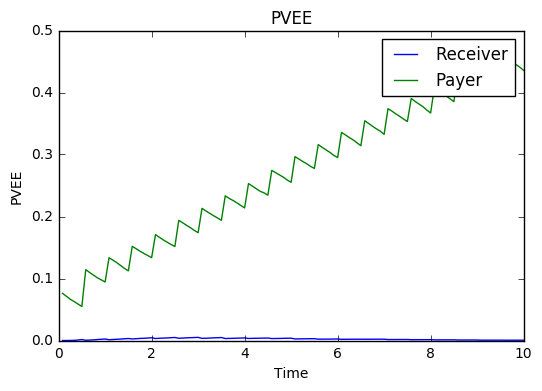

In [6]:
switch_collateral = False
switch_downProv = False
collateral = 0
D = 0
PVEE_payer,EE_payer = calculatePVEE(lbdaCs,P_OISs,X_Cs,prices_payer,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver,EE_receiver = calculatePVEE(lbdaCs,P_OISs,X_Cs,prices_receiver,switch_collateral,switch_downProv,collateral,D)
print "Payer",PVEE_payer
print "Receiver",PVEE_receiver

plt.plot(ts,PVEE_receiver,ts,PVEE_payer)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE')
plt.legend(['Receiver','Payer'])
plt.show()

In [ ]:
wt = chol.dot(np.random.normal(0,1./sim_freq,(4,sim_freq*maturity)))
ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)
X_B,X_C,lbdaB,lbdaC = marketSetup.simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
#plot(ts,X_B,ts,X_C)
print len(X_C)
print len(X_C[1])

In [ ]:
a = np.array([0,1,2,3,4,5,6,7,8,9,10,11,13])
np.where(a[::3]>3)
a[0::3]
np.argmax(a>3)

In [ ]:
a = np.array([0,1,2,-3,4])
print np.maximum(a,0)

In [ ]:
plot(np.average(prices,axis=0));

In [ ]:
np.random.normal(0,1,(4,3))

###### Credit Curve Setting

In [ ]:
# test cell
rho_x = 0.5
C = np.asarray([[1,0],[rho_x,1-rho_x*rho_x]]) # Cholesky decomposition of correlation matrix
wt = C.dot(np.random.normal(0,1,(2,)))
print wt.shape
print np.ones(2).shape
print np.diag(np.asarray([2,3]))
print np.arange(1./12,10.00001,1./12)

In [ ]:
print len(P_OIS[1])
print len(Tis)
print len(P_LIBOR[61])

### 4 IMM Exercise